# Testing Code To Apply PDR Satellite Fraction Finding to UM Model Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table , Column
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline

In [45]:
# import the data file
data_pth = '/Users/astro/Desktop/github/satellite_fraction/data/'
model = data_pth + 'um_smdpl_model_logms_tot_11.4.fits'
pdr = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'


# open pdr file
pdr_open = fits.open(pdr)
z_pdr = pdr_open[1].data['z_best']

In [46]:
# create astropy table of useful data
hdu1 = fits.open(model)
full_table = Table(hdu1[1].data)
# Get only the galaxies within our mass range
model_table = Table(names = full_table.colnames)

for i in range(len(np.array(full_table['logms_tot_mod']))):
    if full_table['logms_tot_mod'][i] > 11.50:
        model_table.add_row(full_table[i])
        
        
model_table.sort('logms_tot_mod')
model_table.reverse() # rank order by mass
model_redshift = 0.37 # this is from um snapshot

## Test halotools

In [48]:
# remember that some galaxies lack specz => error
from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo # um uses planck cosmology
# find the z-space distortions
z_dis = apply_zspace_distortion(model_table['z'], model_table['vz'], model_redshift, cosmo, 400.0)
model_table['z_dist'] = z_dis

Text(0,0.5,'LOS space distortion')

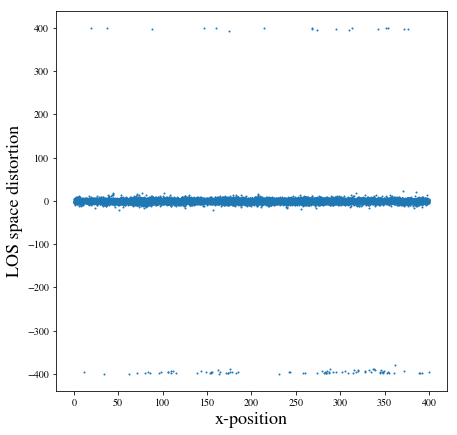

In [49]:
# look at redshift space distortions
fig = plt.figure(figsize = [7,7])

ax1 = fig.add_subplot(111)
ax1.scatter(model_table['x'],model_table['z'] - model_table['z_dist'], s = 1)
ax1.set_xlabel('x-position', fontsize = 18)
ax1.set_ylabel('LOS space distortion', fontsize = 18)

So it looks like the z-space distortions aren't bad. (The odd points at $\pm400$ are from the box size of the um model, which is $400Mpc$)

* Some of the galaxy positions are now weird because of the periodic boundary conditions.

(array([311., 268., 241., 270., 287., 261., 255., 243., 205., 268., 264.,
        246., 221., 195., 203., 225., 220., 278., 246., 241., 247., 287.,
        233., 257., 238., 231., 270., 299., 306., 305., 276., 236., 240.,
        249., 283., 265., 274., 304., 294., 376., 409., 346., 261., 298.,
        313., 302., 221., 250., 270., 270.]),
 array([3.57112194e-02, 8.03437159e+00, 1.60330320e+01, 2.40316923e+01,
        3.20303527e+01, 4.00290131e+01, 4.80276735e+01, 5.60263338e+01,
        6.40249942e+01, 7.20236546e+01, 8.00223149e+01, 8.80209753e+01,
        9.60196357e+01, 1.04018296e+02, 1.12016956e+02, 1.20015617e+02,
        1.28014277e+02, 1.36012938e+02, 1.44011598e+02, 1.52010258e+02,
        1.60008919e+02, 1.68007579e+02, 1.76006239e+02, 1.84004900e+02,
        1.92003560e+02, 2.00002221e+02, 2.08000881e+02, 2.15999541e+02,
        2.23998202e+02, 2.31996862e+02, 2.39995522e+02, 2.47994183e+02,
        2.55992843e+02, 2.63991503e+02, 2.71990164e+02, 2.79988824e+02,
        2.

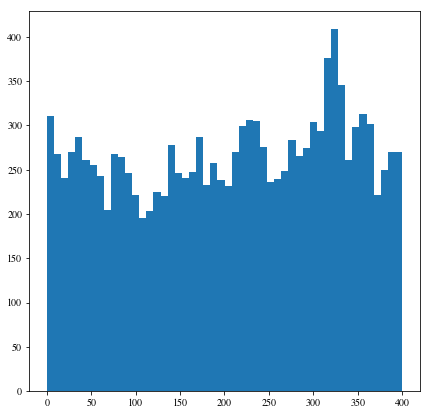

In [50]:
plt.figure(figsize = (7,7))
plt.hist(model_table['z_dist'], bins = 50)

* The next order of business is to turn the $\Delta z$ into physical $\Delta \ell$ (I think). From my conversation with Alexie at Shane, I want to convert our z-limits to comoving $h^{-1}$. For this, I can use `colossus.cosmology.comovingDistance`.

In [20]:
# first define the cosmology in colossus
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params) # this is what Song had me use when doing the sat frac
cosmo = cosmology.setCosmology('huang18')
from colossus.halo import mass_so

In [21]:
# find the comoving distance to use as a z-cut for the catalog
# for the dl cut, I will use the mean redshift plus our velocity dispersion
z_mean = np.mean(z_pdr)
z_l = z_mean + .005 # the .005 is what we will vary in our analysis
l = cosmo.comovingDistance(z_mean, z_l)
print(l)

12.330418377098054


So comoving distance $\Delta \ell \approx 12.33 Mpch^{-1}$ for $\Delta z = 0.005$ 

Now I want to find the satellite fraction through the same process as the pdr region, except with a length cut.


### Apply same method to catalog

In [52]:
# get virial radii
mvir = model_table['logmh_vir']
model_table['r_vir'] = (mass_so.M_to_R((10**mvir)*h , model_redshift, '200m')/h)*1e-3 #Mpc/h


In [53]:
# creating new columns useful for the satellite finding
model_table['flag'] = np.zeros(len(model_table['logms_tot_mod'])) 

model_table['index'] = np.zeros(len(model_table['logms_tot_mod']))
for i in range(len(model_table['index'])):
    model_table['index'][i] = i

$\Rightarrow$ When I am applying this method, there are two key differences from the PDR
* $\Delta z$ cut is now a $\Delta \ell$ cut
* Distance between galaxies is calculated using x-y coordinates instead of RA and Dec

In [55]:
model_table['sep'] = np.zeros(len(model_table['logms_tot_mod'])) #column of angular separations


def satellite(i, table, lcut):
   
    # the object we choose here is going to be a central by the way we have defined things
    cent_gal = model_table[i] 
    
    # this was a trick that song used to make a new catalog for the other objects of interest.
    # the utility is that we don't have to loop through the whole catalog EVERY TIME
    cat_use = copy.deepcopy(model_table[(model_table['logms_tot_mod'] < cent_gal['logms_tot_mod'])])
    
    
    
    # find the galaxies within the delta z limit
    delta_l_cut = cat_use[np.abs(cent_gal['z'] - cat_use['z']) <= lcut] #this creates a new table
    
    if len(delta_l_cut) > 0:
        # find separation for gals within dz (x-y dist)
        delta_l_cut['sep'] = np.sqrt( ((delta_l_cut['x'] - cent_gal['x'])**2) 
                                    + ((delta_l_cut['y'] - cent_gal['y'])**2) )
    for i in range(len(delta_l_cut)):
        if delta_l_cut['sep'][i] <= cent_gal['r_vir']:
            model_table['flag'][int(delta_l_cut['index'][i])] = 1
            #print('satellite, yo')

# loop over the catalog for the lcut from a few cells ago
for idx in range(len(model_table)):
    satellite(idx,model_table,l)
    
model_table.remove_columns(['sep'])

In [56]:
cen_table = Table(names = model_table.colnames)
sat_table = Table(names = model_table.colnames)
for i in range(len(model_table['flag'])):
    if model_table['flag'][i] == 0:
        cen_table.add_row(model_table[i])
    if model_table['flag'][i] == 1:
        sat_table.add_row(model_table[i])    

In [63]:
# range of masses
mmin = np.min(model_table['logms_tot_mod'])
mmax = np.max(model_table['logms_tot_mod'])


# from Song's satellite finding code

hist_cen, edges_cen = np.histogram(cen_table['logms_tot_mod'], range = [11.5,mmax], bins=8)
hist_sat, edges_sat = np.histogram(sat_table['logms_tot_mod'], range = [11.5,mmax], bins=8)

mass_center = (edges_cen[1:] + edges_cen[:-1]) / 2

frac_sat = (hist_sat / hist_cen) * 100

Text(0.5,1,'Model')

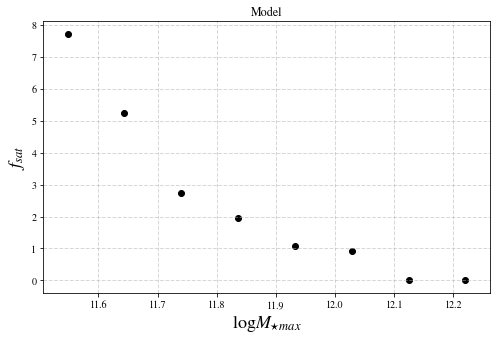

In [64]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.scatter(mass_center , frac_sat, color = 'k')
ax1.set_xlabel(r'$\log M_{\star max}$', fontsize = 18)
ax1.set_ylabel(r'$f_{sat}$', fontsize = 18)
ax1.set_title('Model')